In [458]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [459]:
# alpha0 cose

In [777]:
def SIRD(z, t, S0, beta0, omega, gamma, mu):

    I, R, D = z
    
    S = S0 - I - R - D
    beta = beta0 * np.exp(-omega * t)
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma * I - mu * I
    dR = gamma * I 
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt

def SIRD_mu(z, t, S0, beta0, omega, gamma, mu0, mu_const):

    I, R, D = z
    
    S = S0 - I - R - D
    beta = beta0 * np.exp(-omega * t)
    mu = mu0* (1/ (t+1) +  mu_const)  # perdita di 0.02 R^2
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma * I - mu * I
    dR = gamma * I 
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt


#30: [3.57319214e-01, 5.23649174e+05*2, 1.25344524e-02, 5.27022514e-02, 1.99712696e-02, 1.58864240e-02]
#50: [3.71849011e-01, 4.83512173e+05*2, 1.49740716e-02, 6.18895866e-02, 1.67540531e-02, 1.12222506e-02]
#60: [3.90754345e-01, 1.00025866e+06*2, 1.71339351e-02, 7.09369720e-02, 1.69477925e-02, 9.41203555e-03]

def SIRD_reduced_60(z, t, beta0, gamma, mu0):

    I, R, D = z
    
    S0 = 2000517.32 * beta0 
    S = S0 - I - R - D
    mu = mu0 * (1/(t+1))
    #mu = mu0
    gamma = gamma + np.exp(t-65)/(1 + np.exp(t-65))*0.7*gamma
    beta = beta0* np.exp(-(1.713e-2 + 7.094e-02 * beta0) * t)
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma * I - mu * I
    dR = gamma * I 
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt

def SIRD_reduced_30(z, t, beta0, gamma, mu0):

    I, R, D = z
    
    S0 = 1048000 * beta0 
    S = S0 - I - R - D
    mu = mu0 * (1/(t+1)) 
    beta = beta0* np.exp(-(1.2534e-2 + 5.2702e-02 * beta0) * t)
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma * I - mu * I
    dR = gamma * I 
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt

def SIRD_weird(z, t, beta0, alpha0, alpha1, alpha2, alpha3, gamma, mu):

    I, R, D = z
    
    S0 = (alpha0 + alpha1) * beta0 
    S = S0 - I - R - D
    beta = beta0* np.exp(-(alpha2+alpha3*beta0) * t)
    #mu = mu0 * (1/ (t+1) +  3.77721160e-02)  #7.52593380e-05 : t = 50, #3.77721160e-02, t = 70, 
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma * I - mu * I
    dR = gamma * I 
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt

def SIR(z, t, S0, beta0, omega, gamma):

    I, R = z
    S = S0 - I - R 
    beta = beta0 * np.exp(-omega * t)
    dS = - beta * I * S / N 
    dI = beta * I * S / N - gamma * I
    dR = gamma * I 

    dzdt = [dI, dR]
    return dzdt


def plot_traj_SIRD(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    x4 = trajectories[:,2]

    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Recovered')
    d = plt.plot(x4, linewidth = width, label = 'Deceased')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.title('Real SIRD')
    plt.title('nCov-19 data, Italy')
    plt.tight_layout()
    plt.savefig('sir.png', dpi=500)
    
    
def plot_traj_gray_SIRD(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    x4 = trajectories[:,2]
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')
    d = plt.plot(x4, linewidth = width, color = 'lightgray')
    
    
def plot_traj_SIRD_united(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1] + trajectories[:,2]
    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Removed')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Real SIRD')
    
    
def plot_traj_gray_SIRD_united(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1] + trajectories[:,2]
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')
    
def plot_traj_SIR(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Removed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Real SIRD')

    
    
def plot_traj_gray_SIR(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')

In [778]:
italy = pd.read_csv('Data/Sird_bigdata.csv')

In [779]:
italy.fillna(0, inplace = True)

In [780]:
ext = 150
eff = 30
SIRD_flag = True
italy = italy[:ext]
italy.reset_index(inplace = True, drop = True)

In [781]:
data_size = italy.shape[0]

batch_time = 20 # tempo delle batches
niters = 500
batch_size = data_size - batch_time - 1

if SIRD_flag:
    extended_y = []
    for i in range(ext):
        extended_y.append([italy.loc[i,'Infected'],italy.loc[i,'Recovered'],italy.loc[i,'Dead']])
    extended_y = np.array(extended_y)
else:
    extended_y = []
    for i in range(ext):
        extended_y.append([italy.loc[i,'Infected'],italy.loc[i,'Recovered']+italy.loc[i,'Dead']])
    extended_y = np.array(extended_y)

nonorm_y = extended_y.copy()

In [782]:
italy = italy[:eff]
italy.reset_index(inplace = True, drop = True)
#italy

In [783]:
data_size = italy.shape[0]

batch_time = 15  # tempo delle batches
niters = 500
batch_size = data_size - batch_time - 1

if SIRD_flag:
    true_y = []
    for i in range(data_size):
        true_y.append([italy.loc[i,'Infected'],italy.loc[i,'Recovered'],italy.loc[i,'Dead']])
    true_y = np.array(true_y)
else:
    true_y = []
    for i in range(data_size):
        true_y.append([italy.loc[i,'Infected'],italy.loc[i,'Recovered']+italy.loc[i,'Dead']])
    true_y = np.array(true_y)

nonorm_y = true_y.copy()

In [784]:
italy['Date'] = pd.to_datetime(italy['Date'])

t_grid = np.arange(data_size)

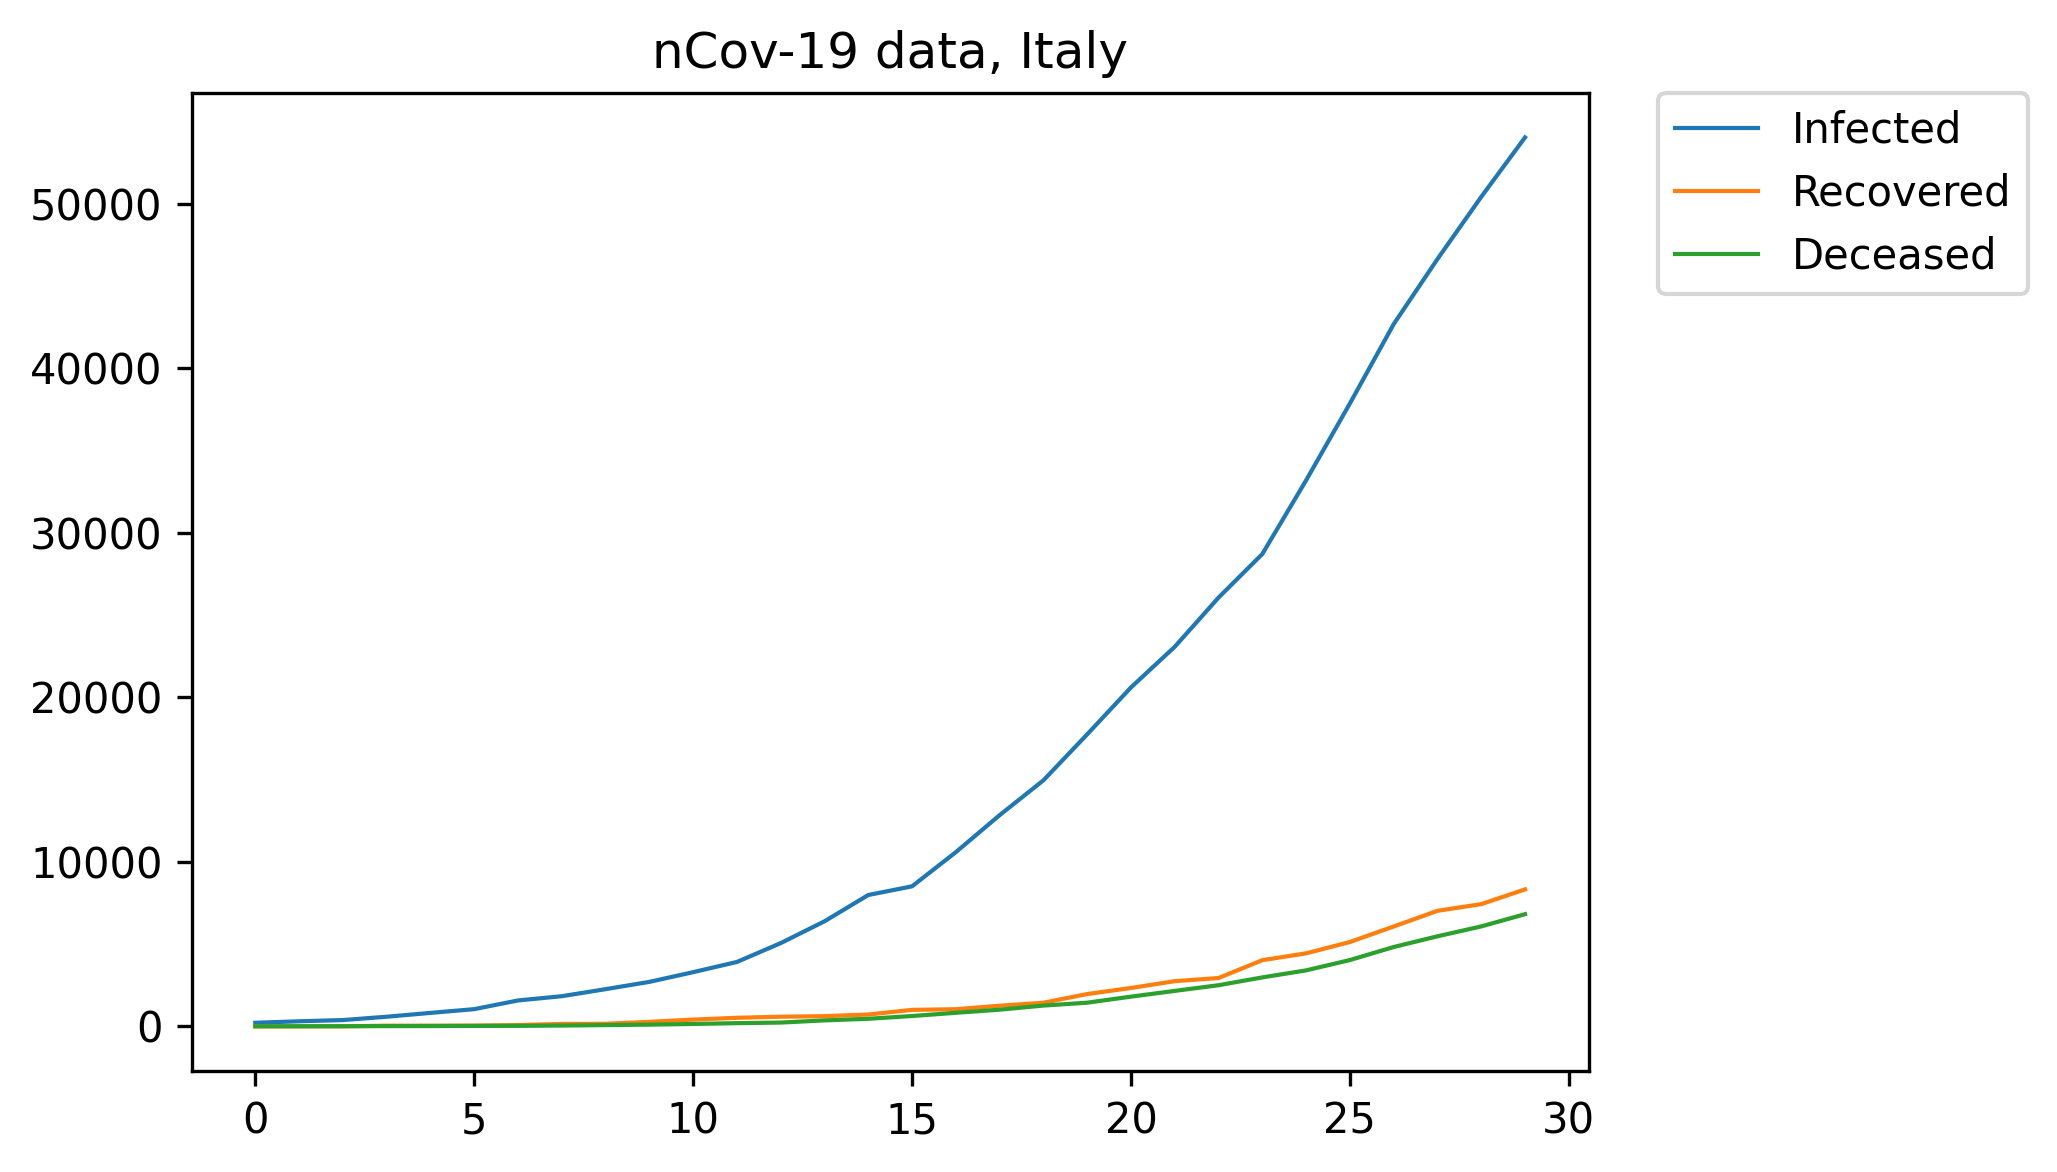

In [785]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(7, 4), dpi=150, facecolor='w', edgecolor='k')

if SIRD_flag:
    plot_traj_SIRD(true_y)
else:
    plot_traj_SIR(true_y)

In [787]:
from scipy import integrate, optimize

if SIRD_flag:
    true_yy = np.append(true_y[:,0],true_y[:,1])
    true_yy = np.append(true_yy,true_y[:,2])

    def fit_odeint_mu(x, S0, beta0, omega, gamma, mu0, mu_const):
        fit = integrate.odeint(SIRD, (221,1,7), x, args=(S0,beta0,omega, gamma, mu0, mu_const))
        fit_p = np.append(fit[:,0],fit[:,1])
        return np.append(fit_p,fit[:,2])
    
    def fit_odeint(x, S0, beta0, omega, gamma, mu):
        fit = integrate.odeint(SIRD, (221,1,7), x, args=(S0,beta0,omega, gamma, mu))
        fit_p = np.append(fit[:,0],fit[:,1])
        return np.append(fit_p,fit[:,2])

    def fit_odeint_weird(x, beta0, alpha0, alpha1, alpha2, alpha3, gamma, mu):
        fit = integrate.odeint(SIRD_weird, (221,1,7), x, args=(beta0, alpha0, alpha1, alpha2, alpha3, gamma, mu))
        fit_p = np.append(fit[:,0],fit[:,1])
        return np.append(fit_p,fit[:,2])
    
    def fit_odeint_reduced_60(x, beta0, gamma, mu0):
        fit = integrate.odeint(SIRD_reduced_60, (221,1,7), x, args=(beta0, gamma, mu0))
        fit_p = np.append(fit[:,0],fit[:,1])
        return np.append(fit_p,fit[:,2])

    #S0, alpha1, alpha2, alpha3, alpha4, gamma, mu
    #popt, pcov = optimize.curve_fit(fit_odeint, xdata = t_grid, ydata =  true_yy, p0 = (2000000, 0.5, 0.1, 0.1, 0.1), bounds=(0, [61000000, 5, 1, 1, 1]))
    #popt, pcov = optimize.curve_fit(fit_odeint_weird, xdata = t_grid, ydata =  true_yy, p0 = (0.1, 1000000, 1000000, 0.1, 0.1, 0, 0.1), bounds=(0, [1, np.inf, np.inf, 1, 1, 1, 1]))
    popt, pcov = optimize.curve_fit(fit_odeint_reduced_60, xdata = t_grid, ydata =  true_yy, p0 = (0.1, 0.1, 0.1), bounds=(0, [1, 1, 1]))

else:
    true_yy = np.append(true_y[:,0],true_y[:,1])

    def fit_odeint(x, S0, beta0, omega, gamma):
        fit = integrate.odeint(SIR, (221,8), x, args=(S0,beta0, omega, gamma))
        return np.append(fit[:,0],fit[:,1])

    popt, pcov = optimize.curve_fit(fit_odeint, xdata = t_grid, ydata =  true_yy, p0 = (2000000, 0.5, 0.1, 0.1), bounds=(0, [61000000, 5, 1, 1]))
    

popt, pcov

(array([0.45709155, 0.01779442, 0.27679651]),
 array([[ 1.67916346e-05,  6.01174170e-07,  4.49582140e-05],
        [ 6.01174170e-07,  3.10857070e-07, -5.85959179e-07],
        [ 4.49582140e-05, -5.85959179e-07,  1.39131995e-04]]))

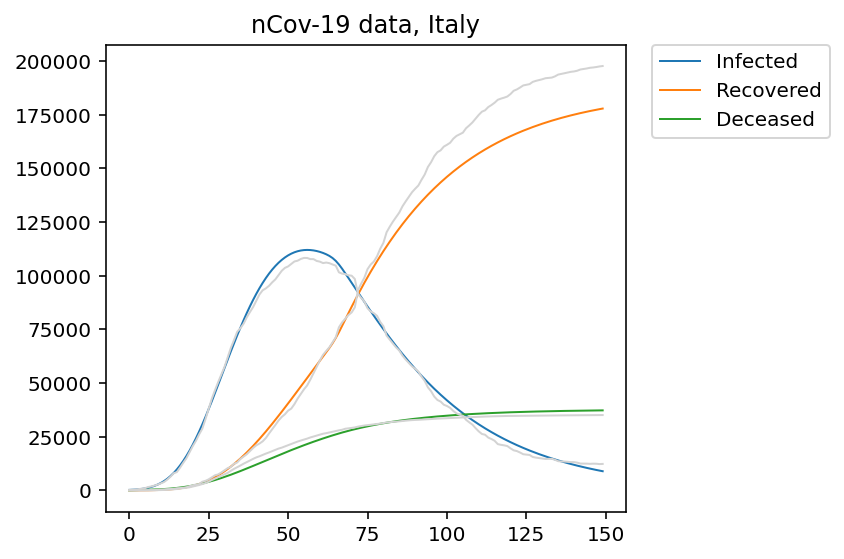

In [788]:
if SIRD_flag:
    simul_yy =  odeint(SIRD_reduced_60, (221,1,7), np.arange(ext), args=tuple(np.reshape(popt,(1,-1))[0]))
    plot_traj_SIRD(simul_yy)
    plot_traj_gray_SIRD(extended_y)
else:
    simul_yy =  odeint(SIR, (221,8), np.arange(ext), args=tuple(np.reshape(popt,(1,-1))[0]))
    plot_traj_SIR(simul_yy)
    plot_traj_gray_SIR(extended_y)

In [789]:
extended_yy = np.append(extended_y[:,0],extended_y[:,1])
extended_yy = np.append(extended_yy,extended_y[:,2])

In [790]:
residuals = np.ravel(extended_yy) - fit_odeint_reduced_60(np.arange(ext), *popt)
ss_res = np.sum(residuals**2)

ss_tot = np.sum((np.ravel(extended_yy)-np.ravel(np.mean(extended_yy)))**2)

r_squared = 1 - (ss_res / ss_tot)

r_squared 

0.9851333823991067

Text(0.5, 1.0, 'Correlation Matrix')

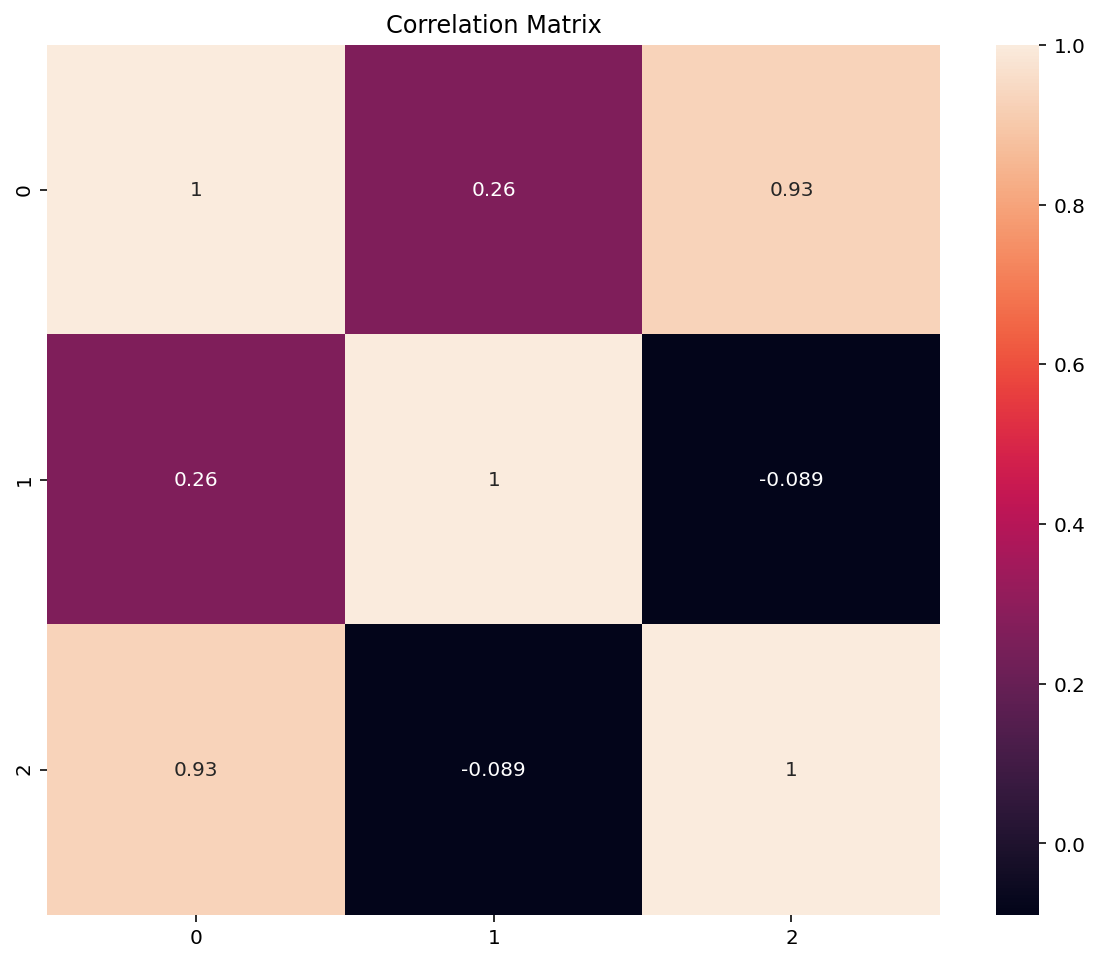

In [791]:
def compute_corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

import seaborn as sns

corr = compute_corr(pcov)

plt.figure(figsize=(10,8))

sns.heatmap(corr, annot = True)

plt.title("Correlation Matrix")




In [792]:
"""
sigma_i = np.std(true_y[:,0:1])  
sigma_r = np.std(true_y[:,1:2]) 
sigma_d = np.std(true_y[:,2:3])  

true_y[:, 0:1] = true_y[:, 0:1]/sigma_i
true_y[:, 1:2] = true_y[:, 1:2]/sigma_r
true_y[:, 2:3] = true_y[:, 2:3]/sigma_d
"""

# mmm mi sa che c'è troppa differenza

'\nsigma_i = np.std(true_y[:,0:1])  \nsigma_r = np.std(true_y[:,1:2]) \nsigma_d = np.std(true_y[:,2:3])  \n\ntrue_y[:, 0:1] = true_y[:, 0:1]/sigma_i\ntrue_y[:, 1:2] = true_y[:, 1:2]/sigma_r\ntrue_y[:, 2:3] = true_y[:, 2:3]/sigma_d\n'

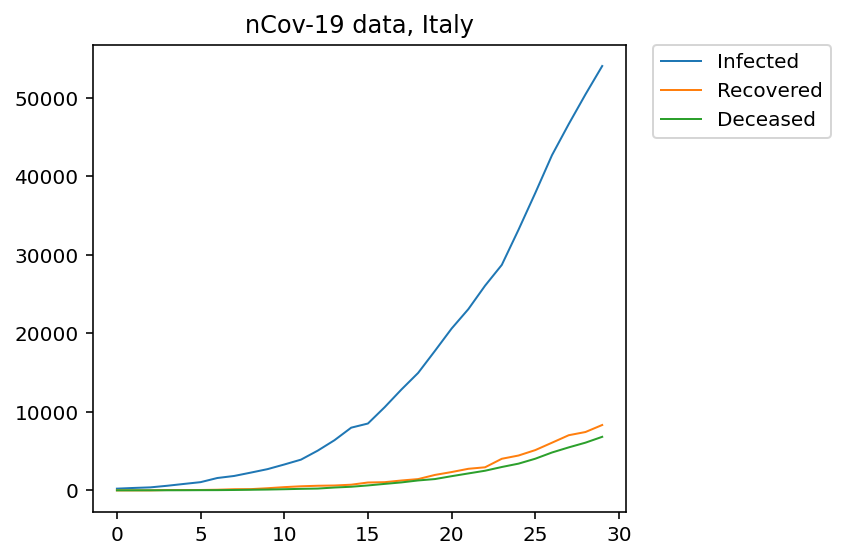

In [793]:
if SIRD_flag:
    plot_traj_SIRD(true_y)
else:
    plot_traj_SIR(true_y)

In [794]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    # being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [795]:
num_param = 3 # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 10)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch


In [796]:
"""
from neural_ode import NeuralODE

niters_pre = 200  # Number of iterations of the preconditioner

if SIRD_flag:
    class ODEModel_pre(tf.keras.Model):
        def __init__(self):
            super(ODEModel_pre, self).__init__()
            self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer: assign normally distributed random weights which are very close to zero

        def call(self, inputs, **kwargs):
            t, y = inputs
            h = y
            
            beta0 = self.Weights[0]
            gamma = self.Weights[1]
            mu = self.Weights[2]
            
            
            I = h[:, 0:1] 
            R = h[:, 1:2] 
            D = h[:, 2:3] 
        
            S0 = 2000517.32 * beta0
            S = S0 - I - R - D
        
            beta = beta0 * tf.exp(-(1.713e-2 + 7.094e-02 * beta0) * t)

            dI = beta * I * S / S0 - gamma * I - mu * I
            dR = gamma * I 
            dD = mu * I

            h_out = tf.concat([dI/sigma_i, dR/sigma_r, dD/sigma_d], 1)
            return h_out


model_pre = ODEModel_pre()  
neural_ode_pre = NeuralODE(model_pre, t_in) 
optimizer = tf.compat.v1.train.AdamOptimizer(1e-1)

# scrivere gradient descent meno vanilla

@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    #Takes start positions (x0, y0) and final positions (xN, yN)
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

parameters_pre = np.zeros(num_param)

losses = []

for step in tqdm(range(niters_pre)):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    #print(loss, dWeights)
    losses.append(loss)
    parameters_pre = model_pre.trainable_weights[0].numpy()
print(parameters_pre)

plt.plot(losses)

@tf.function
def compute_loss(batch_y0, batch_yN, neuralodes):
    pred_y = neuralodes.forward(batch_y0)  # This finds the predicted yNs
    loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2)
    return loss

temp_model = ODEModel_pre()
neural_ode_temp = NeuralODE(temp_model, t=t_in)
w_temp = np.resize(np.array(popt),(3,1))
temp_model.trainable_weights[0].assign(w_temp) 
compute_loss(batch_y0,batch_yN,neural_ode_temp)

"""

'\nfrom neural_ode import NeuralODE\n\nniters_pre = 200  # Number of iterations of the preconditioner\n\nif SIRD_flag:\n    class ODEModel_pre(tf.keras.Model):\n        def __init__(self):\n            super(ODEModel_pre, self).__init__()\n            self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)\n        # Initializer: assign normally distributed random weights which are very close to zero\n\n        def call(self, inputs, **kwargs):\n            t, y = inputs\n            h = y\n            \n            beta0 = self.Weights[0]\n            gamma = self.Weights[1]\n            mu = self.Weights[2]\n            \n            \n            I = h[:, 0:1] \n            R = h[:, 1:2] \n            D = h[:, 2:3] \n        \n            S0 = 2000517.32 * beta0\n            S = S0 - I - R - D\n        \n            beta = beta0 * tf.exp(-(1.713e-2 + 7.094e-02 * beta0) * t)\n\n            dI = beta * I * S / S0 - gamma * I - mu * I\n    

In [797]:
def compute_loss(params):
    residuals = true_yy - fit_odeint_reduced_60(np.arange(eff), *params)
    loss = np.sum(residuals**2)/(1e9)
    return loss

In [798]:
# These 2 functions sample from a truncated Gamma distribution by using the inverse cdf method. The first one
#  samples from the interval [a, +inf), the second one from [0, a)

import scipy.stats as sps
import numpy.random as npr

def trGamma_a_inf(shape, rate, trunc):
    interval = 1 - sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    yr = npr.rand(1)*interval + sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    xr = sps.gamma.ppf(yr, a = shape, scale = 1/rate)
    return(xr[0])

def trGamma_0_a(shape, rate, trunc):
    interval = sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    yr = npr.rand(1)*interval
    xr = sps.gamma.ppf(yr, a = shape, scale = 1/rate)
    return(xr[0])

In [799]:
def adaptive_gamma_sampling(true_center, shape, rate, quantile_1, quantile_2):
    if ((sps.gamma.cdf(true_center, a=shape, scale=1/rate) < quantile_1) | (sps.gamma.cdf(true_center, a=shape, scale=1/rate) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        loc = sps.gamma.mean(a=shape, scale=1/rate)
        if true_center > loc:
            trunc = loc + par*(true_center-loc)
            w_temp = trGamma_a_inf(shape=shape, rate=rate, trunc=trunc)
        else:
            trunc = loc + par*(true_center-loc)
            w_temp = trGamma_0_a(shape=shape, rate=rate, trunc=trunc)
    else:
        w_temp = sps.gamma.rvs(a = shape, scale=1/rate)
    
    return(w_temp)


def border_estimates_e_abc(eps, niters):
    
    
    # This function estimates the borders of the region containing the eps-approximate posterior through niters 
    #  iterations. It uses the empirical sampling method to get nearer to the correct acceptance region.
    #  This is only used to estimate borders, though it can estimate also the parameters in order to avoid 
    #  biases in the estimation.

    import scipy.stats as sps

    initial_loss = 0
    
    # temp_model.trainable_weights[0].assign(parameters_pre) 
    # initial_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) 
    # print(initial_loss)

    naccepted = 0
    
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = np.zeros(num_param)
    
    prior_means = np.array([3.96624060e-01, 3.69362920e-02, 2.33723259e-03])  # Estimation of means from China data
    
    for i in tqdm(range(niters)):

        lambda_temp = [npr.uniform(low = 10, high = 20),npr.uniform(low = 10, high = 20),npr.uniform(low = 10, high = 20)] #200

        alpha_quant = 0.25 # crasha ogni volta, ogni volta dopo un numero differente di iterazioni.
        # trovato su stackoverflow:
                #I've encountered the same problem as well. 
                #The thing is that the lower bound a is above (or close to) the 99% quantile of the Normal distribution.
                #Thus the truncation causes scipy to crash.
                #The only solution I came out with is to check before truncation if myclip_a is above the 99% quantile and
                #if so avoid the update. I hope that someone will find a better solution than mine!

        w_temp = [adaptive_gamma_sampling(true_center=popt[j], shape=lambda_temp[j]*prior_means[j], rate=lambda_temp[j], quantile_1=alpha_quant, quantile_2=1-alpha_quant) for j in range(len(w_temp))]

        # After the sampling from the prior we go on by simulating the model
        # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)

        sim_loss = compute_loss(w_temp)
        loss.append(sim_loss)

        # if abc_distance(initial_trajectories, sim_trajectories) < eps:
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3) and all(w >= 0 for w in w_temp):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            #lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    #lambdalist = lambdalist[0:naccepted,:]
    
    borders =  [np.min(parameters[:,i]) for i in range(num_param)]

    return(borders)

In [800]:
def e_abc_gamma_sampling(true_center, shape, rate, border):
    
    # This function performs the empirical sampling from our method when the "true center" is too far from
    #  the center of the prior.
    
    loc = sps.gamma.mean(a=shape, scale=1/rate)
    q = 0.25
    
    #if ((sps.gamma.cdf(true_center, a=shape, scale=1/rate) < q) | (sps.gamma.cdf(true_center, a=shape, scale=1/rate) > 1-q)):
    #    if true_center < loc:
    #        w_temp = trGamma_a_inf(shape=shape, rate=rate, trunc=border)
    #    else:
    #        w_temp = trGamma_0_a(shape=shape, rate=rate, trunc=border)
    #else:
    #    w_temp = sps.gamma.rvs(a = shape, scale=1/rate)
    
    w_temp = trGamma_a_inf(shape=shape, rate=rate, trunc=border)
    
    return(w_temp)

In [801]:
def preprocessing_e_abc(eps, niters, borders):

    # This function performs the first sampling from the region defined through the borders estimating function and
    #  returns the estimated parameters and the initializing weights, ([1,1,1,...,1] normalized)
    
    import scipy.stats as sps
    initial_loss = 0

    naccepted = 0

    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = np.zeros(para_num)

    prior_means = np.array([3.96624060e-01, 3.69362920e-02, 2.33723259e-03])  # Estimation of means from china data
    
    for i in tqdm(range(niters)):

        lambda_temp = np.array([npr.uniform(low = 10, high = 20),npr.uniform(low = 10, high = 20),npr.uniform(low = 10, high = 20)]) # 200

        w_temp = [e_abc_gamma_sampling(popt[j], lambda_temp[j]*prior_means[j], lambda_temp[j], borders[j]) for j in range(len(popt))]
        
        sim_loss =  compute_loss(w_temp)
        loss.append(sim_loss)

        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            #lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    #lambdalist = lambdalist[0:naccepted,:]

    weights = np.ones(parameters.shape[0])/parameters.shape[0]
    
    return(parameters, weights)

In [802]:
def compute_weights_abc_smc(w, loc, scale, prev_w, prev_p, scale_kernel):
    
    # This function computes the weights associated to each parameter as described in https://arxiv.org/pdf/1106.6280.pdf
    
    prob_w = 1
    for i in range(para_num):
        prob_w *= sps.norm.pdf(w[i], loc=loc, scale=scale)
    
    previous_w = 0
    for i in range(prev_w.shape[0]):
        kern_w = 1
        for j in range(para_num):
            kern_w *= sps.norm.pdf(w[j], loc=prev_p[i,j], scale=scale_kernel[j])
        previous_w += prev_w[i]*kern_w
    
    return(prob_w/previous_w)

def normalize_weights(weights):
    
    # This function performs the normalization of weights
    
    tot_weight = np.sum(weights)
    return(weights/tot_weight)

def sample_abc_smc_element(parameters, weights):
    
    # This function samples from the previous population according to the specified weights
    
    elements = np.arange(parameters.shape[0])
    idx = np.random.choice(elements, 1, p=weights)
    return(parameters[idx,])

def perturbation_kernel(sdev):
    
    # This function returns the perturbation from a Gaussian kernel with the specified standard deviation
    
    return([np.random.randn()*sdev[i] for i in range(para_num)])

In [803]:
def sample_abc_smc(eps, niters, kernel_std, old_parameters, weights): 
    
    # This function returns the sampling according to the ABC-SMC with the weights associated to old parameters
    # specified in weights and the old parameters specified in old_parameters
    
    import scipy.stats as sps

    initial_loss = 0

    naccepted = 0
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []
    new_weights = []

    lambda_temp = 0
    w_temp = np.zeros(para_num)

    for i in tqdm(range(niters)):

        # Extracting from previous population with specified weights
        w_temp = sample_abc_smc_element(old_parameters, weights)
        
        # Perturbating with the gaussian Kernel
        pert = perturbation_kernel(kernel_std)
        w_temp = w_temp + pert

        w_temp = np.resize(w_temp, (para_num,))

        sim_loss =  compute_loss(w_temp)
        loss.append(sim_loss)

        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            #lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1
            lambda_temp = npr.uniform(low = 0, high = 1.5) # CAMBIARE LA FUNZIONE CHE PRENDE IN INGRESSO
            new_weights.append(compute_weights_abc_smc(w_temp, 0, 1/lambda_temp, weights, old_parameters, kernel_std)) 
            
        
    print('Acceptance rate: ', naccepted / niters)

    new_weights = normalize_weights(new_weights)
    new_weights = new_weights.reshape(naccepted)
    
    parameters = parameters[0:naccepted,:]
    #lambdalist = lambdalist[0:naccepted,:]
    
    return(parameters, new_weights)

In [804]:
import scipy.stats as sps

eps = 10*compute_loss(popt)
niters = 3000
std_dev_start = [0.2, 0.01, 0.2]

print("Borders estimation start...")
borders = border_estimates_e_abc(eps, 10*niters)

  0%|                                                                              | 33/30000 [00:00<01:32, 324.41it/s]

Borders estimation start...


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:26<00:00, 345.76it/s]

Acceptance rate:  0.022366666666666667


In [805]:
print(borders)
print("Borders estimation completed, starting preprocessing...")
start, start_weights = preprocessing_e_abc(eps, 5*niters, borders)
print("Preprocessing completed, starting ABC-SMC")

  0%|▏                                                                             | 34/15000 [00:00<00:44, 334.12it/s]

[0.3479606629184156, 3.1301891357482767e-06, 0.014703934617193867]
Borders estimation completed, starting preprocessing...


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:43<00:00, 343.66it/s]

Acceptance rate:  0.026466666666666666
Preprocessing completed, starting ABC-SMC


In [806]:
# cambiare i lambda anche in smc

parameters, weights = sample_abc_smc(eps/2, 2*niters, np.std(start, axis=0), start, start_weights)
parameters, weights = sample_abc_smc(eps/3, 2*niters, np.std(parameters, axis=0), parameters, weights)
parameters, weights = sample_abc_smc(eps/4, 2*niters, np.std(parameters, axis=0), parameters, weights)

  0%|                                                                                 | 9/6000 [00:00<01:16, 78.45it/s]

Acceptance rate:  0.030333333333333334


  0%|▏                                                                               | 12/6000 [00:00<01:38, 60.77it/s]

Acceptance rate:  0.1115


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:16<00:00, 78.91it/s]

Acceptance rate:  0.0615


In [248]:
parameters, weights = sample_abc_smc(eps/4, niters, np.std(parameters, axis=0), parameters, weights)
parameters, weights = sample_abc_smc(eps/5, 10*niters, np.std(parameters, axis=0), parameters, weights)

  0%|                                                                                | 1/30000 [00:00<57:51,  8.64it/s]

Acceptance rate:  0.10233333333333333


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [07:40<00:00, 65.17it/s]

Acceptance rate:  0.08666666666666667


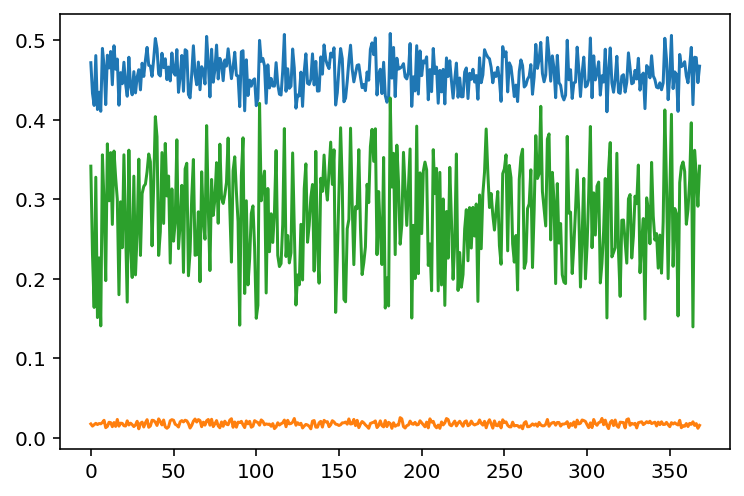

In [807]:
plt.plot(parameters)

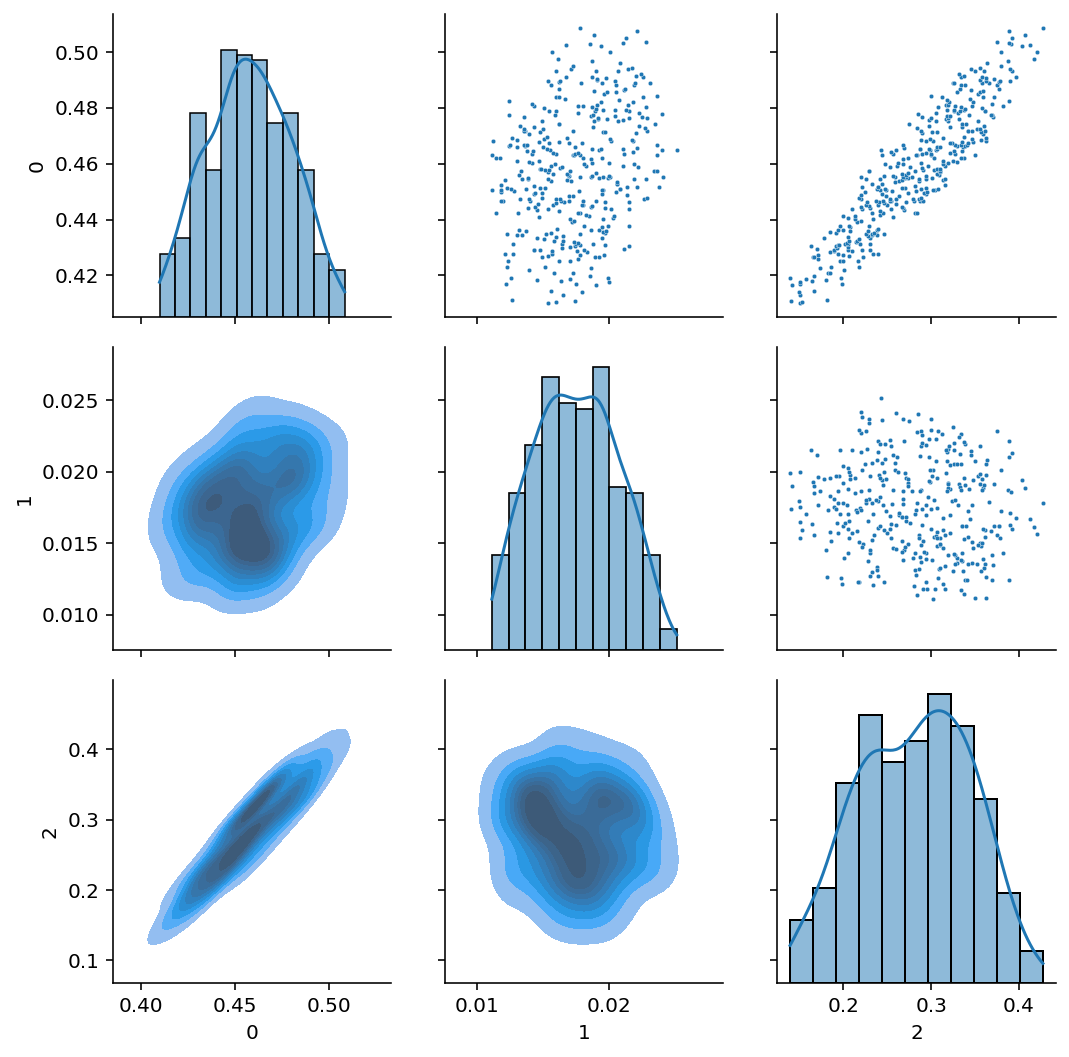

In [808]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(np.unique(parameters, axis = 0)))
g.map_upper(sns.scatterplot, s = 5)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

<AxesSubplot:title={'center':'x'}>

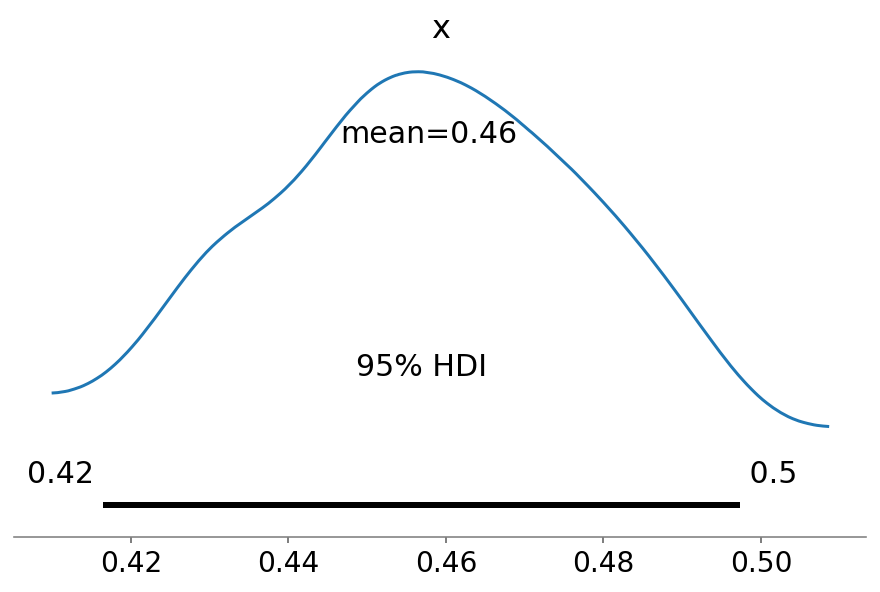

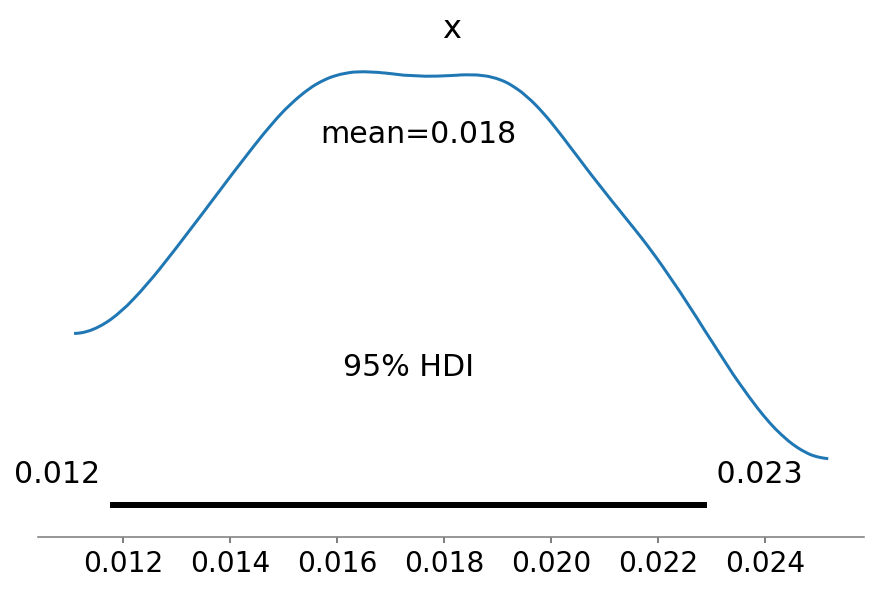

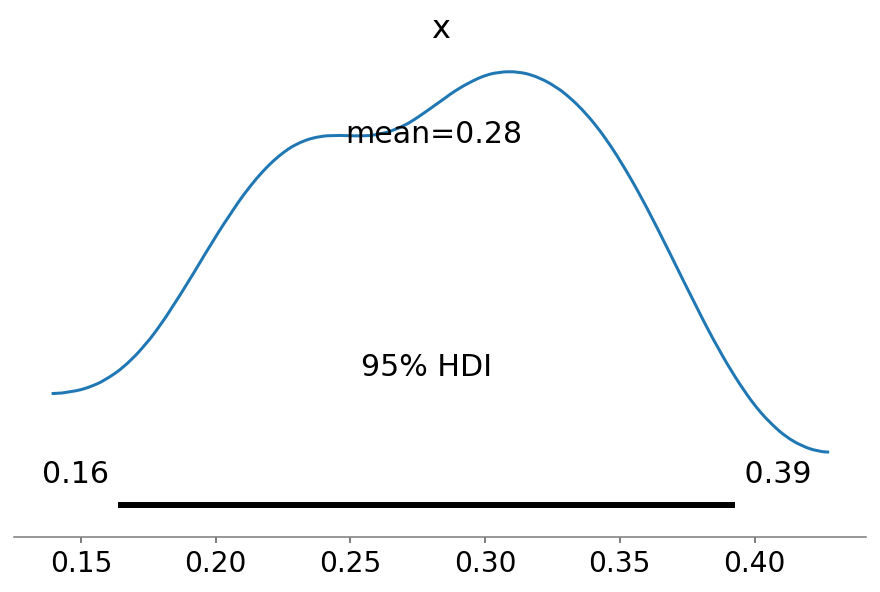

In [809]:
import arviz as az

az.plot_posterior(parameters[:,0],hdi_prob = 0.95)
az.plot_posterior(parameters[:,1],hdi_prob = 0.95)
az.plot_posterior(parameters[:,2],hdi_prob = 0.95)

In [173]:
#np.save('parameters_new.npy',parameters)
#np.save('weights_new.npy',weights)

In [37]:
parameters = np.load('parameters_new.npy')
weights = np.load('weights_new.npy')

100%|███████████████████████████████████████████████████████████████████████████████| 369/369 [00:02<00:00, 175.18it/s]


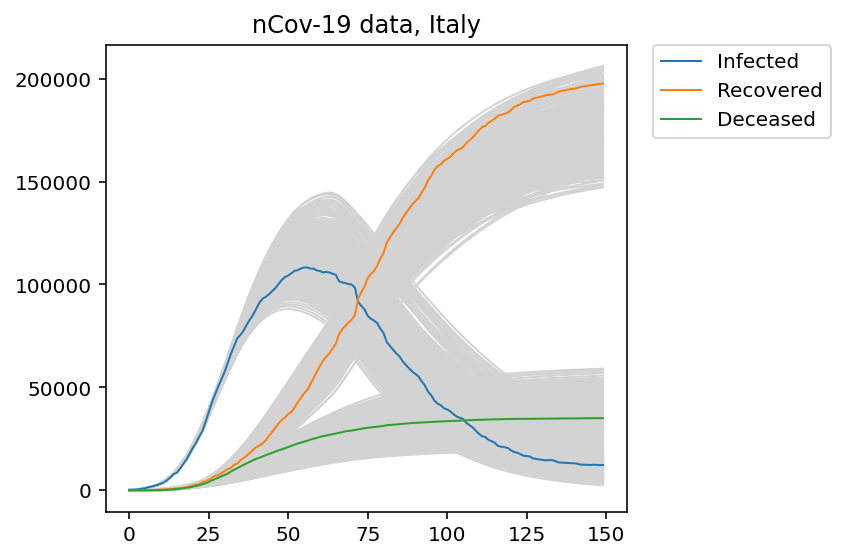

In [810]:
for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SIRD_reduced_60, [221,1,7], np.arange(ext), args=tuple(parameters[j]))
    plot_traj_gray_SIRD(simul_yy)

plot_traj_SIRD(extended_y)

plt.show()

# advancements -> use side information (chiusura ecc) + forma parametrica diversa
# aggiungere modello areale ( o su grafi)
# aggiungere info su icu, hospitalised ecc -> suihter model
# epsilon scelto automaticamente guardando l'intorno del preconditioning? (illegale mi sa)
# https://github.com/pcm-dpc/COVID-19/blob/master/dati-regioni/dpc-covid19-ita-regioni-20200224.csv per dati anche regionali

100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:01<00:00, 334.00it/s]


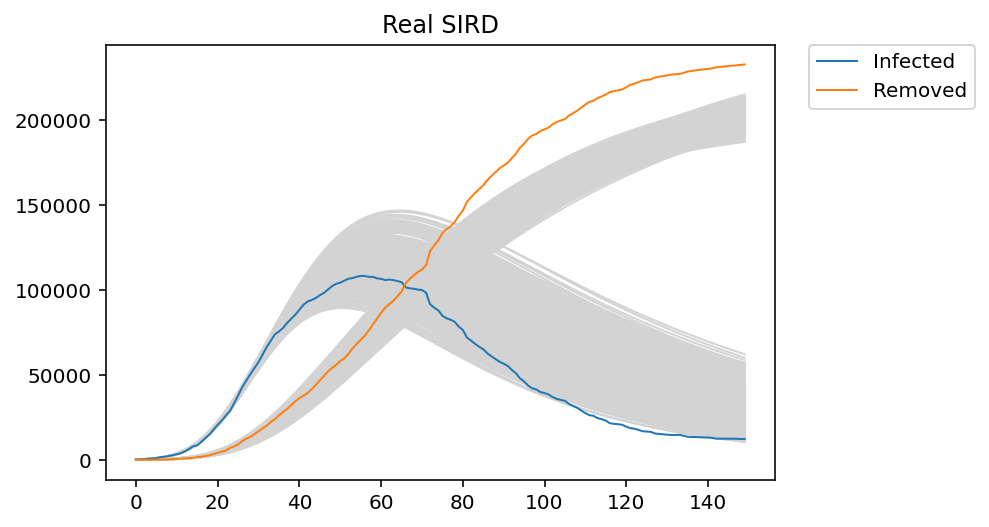

In [731]:
for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SIRD_reduced_60, [221,1,7], np.arange(ext), args=tuple(parameters[j]))
    plot_traj_gray_SIRD_united(simul_yy)

plot_traj_SIRD_united(extended_y)

plt.show()

In [575]:
t = np.arange(ext)

100%|██████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2373.48it/s]


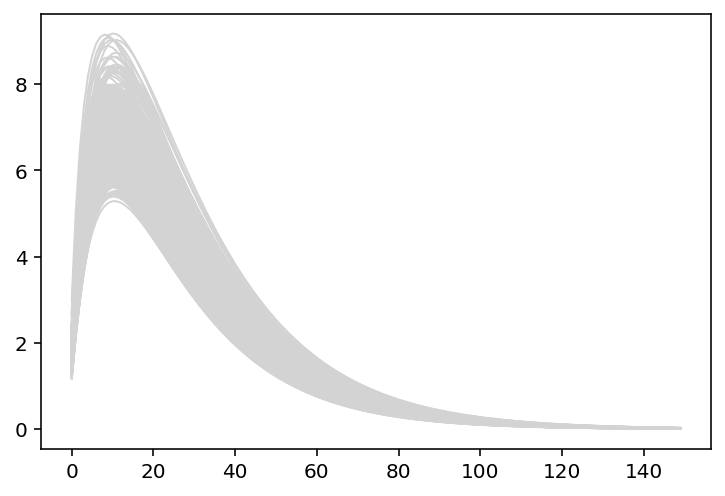

In [732]:
for j in tqdm(range(parameters.shape[0])):
    plt.plot(t, parameters[j,0]* np.exp(-(1.713e-2 + 7.094e-02 * parameters[j,0]) * t)/(parameters[j,1]+parameters[j,2]/(t+1)),linewidth = 1, color = 'lightgray')


In [ ]:
parameters, weights = sample_abc_smc(eps/5, 25*niters, np.std(parameters, axis=0), parameters, weights)

# FAR RUNNARE

In [ ]:
simul_yy =  odeint(SIRD_reduced_60, [221,1,7], np.arange(ext), args=tuple(np.reshape(parameters_pre,(1,-1))[0]))
plot_traj_SIRD(simul_yy)
plot_traj_gray_SIRD(extended_y)